In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import yaml
import os, sys, datetime
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv
load_dotenv(dotenv_path='keys.env')
KEYS = {
    'openai': os.getenv('OPENAI_API_KEY')
}
os.environ['OPENAI_API_KEY'] = KEYS['openai']

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import SingleTurnSample 
from ragas.metrics import ResponseRelevancy, Faithfulness, AspectCritic, FactualCorrectness, BleuScore, RougeScore, SemanticSimilarity
from ragas.metrics._string import NonLLMStringSimilarity, DistanceMeasure
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_palette('colorblind')

import utils_validation as uv


evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [43]:
labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = uv.load_pred_and_annot(fp_pred='outputs/2025-05-28/clean_entity_type_map.yaml',
                                                                                         fp_annot='outputs/annotations/ground_truth_metadata_annotations-2025-06-03.yaml')


Loaded 15 annotations and predictions.


Text(0.5, 0, 'Fraction of datasets with annotations')

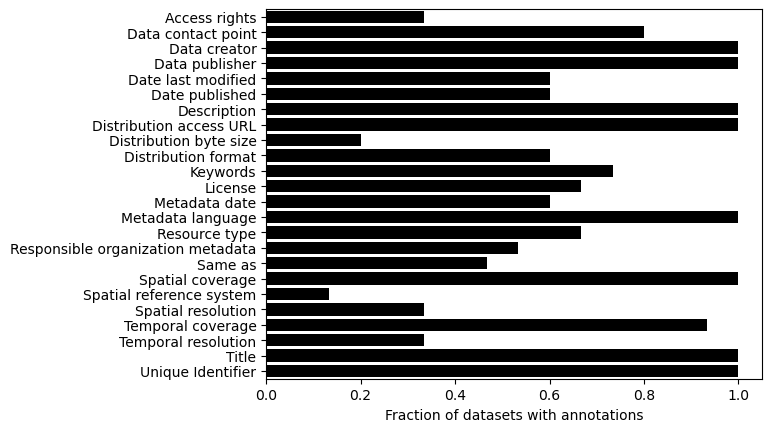

In [40]:
df_annot_present = pd.DataFrame({m: [labels_annot.get_text(url, m) != 'N/A' for url in labels_annot.keys()] for m in list_metadata_fields})
sns.barplot(data=df_annot_present, orient='h', errorbar=None, color='black')
plt.xlabel('Fraction of datasets with annotations')

In [ ]:
## apply counter to each column:
df_annot_present = df_annot_present.apply(lambda x: x.value_counts(normalize=True), axis=0).fillna(0)
# for c in df_annot_present.columns:
#     assert df_annot_present[c].dtype == int, c

df_annot_present

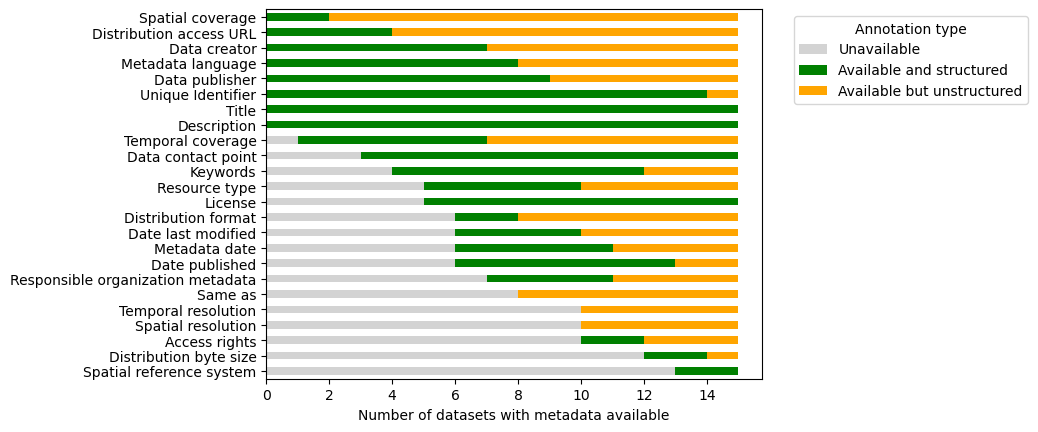

In [77]:
df_annot_present = pd.DataFrame({m: [labels_annot.get_findability(url, m) for url in labels_annot.keys()] for m in list_metadata_fields})
df_annot_present = df_annot_present.apply(lambda x: x.value_counts(normalize=False), axis=0).fillna(0)
df_annot_present = df_annot_present.reindex([0, 1, 2], fill_value=0).T
df_annot_present = df_annot_present.sort_values(by=[0, 1, 2], ascending=False)
legend_dict = {0: 'Unavailable', 1: 'Available and structured', 2: 'Available but unstructured'}
df_annot_present = df_annot_present.rename(columns=legend_dict)
df_annot_present.plot(kind='barh', stacked=True, color=['#d3d3d3', '#008000', '#ffa500'])
plt.xlabel('Number of datasets with metadata available')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Annotation type')

In [130]:
uv.specify_and_convert_metadata_fields(uv.load_yaml(fp_annot), metadata_format='croissant')

{'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': {'Data creator': {'findability': 1,
   'text': 'Wageningen Marine Research'},
  'Data publisher': {'findability': 1, 'text': 'Datahuis Wadden'},
  'Date last modified': {'findability': 2, 'text': datetime.date(2016, 11, 1)},
  'Date published': {'findability': 1, 'text': datetime.date(2016, 11, 1)},
  'Description': {'findability': 1,
   'text': 'For the proper management of areas such as the Wadden Sea, a consistent and unambiguous insight into the changes in the various landscape units is of great importance. One of the ways to make changes in ecosystems and landscapes visible is with ecotope maps. Ecotopes are “spatially delimited ecological units, the composition and development of which are determined by abiotic, biotic and anthropogenic conditions on site. An ecotope is a recognizable, more or less homogeneous landscape unit.” (Bouma et al., 2005). Ecotope maps are derived from a number of u

In [145]:

fp_pred='outputs/2025-06-03/croissant_gemini_clean_entity_type_map.yaml'
fp_annot='outputs/annotations/ground_truth_metadata_annotations-2025-06-04.yaml'
labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = uv.load_pred_and_annot(fp_pred=fp_pred, 
                                                                        fp_annot=fp_annot, keep_annotated_fields_only=True,
                                                                        metadata_format='croissant')

labels_pred

Loaded 16 annotations and predictions.


Labels(16 URLs, 10 metadata fields: ['Data creator', 'Data publisher', 'Date last modified', 'Date published', 'Description', 'Keywords', 'License', 'Metadata language', 'Same as', 'Title'])

In [146]:
labels_pred

Labels(16 URLs, 10 metadata fields: ['Data creator', 'Data publisher', 'Date last modified', 'Date published', 'Description', 'Keywords', 'License', 'Metadata language', 'Same as', 'Title'])

Evaluate all datasets:


In [3]:
test_llm_metrics = False
# fp_pred='outputs/2025-05-28/clean_entity_type_map.yaml'
# fp_pred='outputs/2025-06-03/cedar_openai_clean_entity_type_map.yaml'
folder_pred = 'outputs/2025-06-04/'
fp_pred_list = os.listdir(folder_pred)
fp_annot='outputs/annotations/ground_truth_metadata_annotations-2025-06-04.yaml'

cols_evaluation = ['llm_name', 'metadata_format', 'processing_stage', 'url', 'metadata_field', 'findability',  
                   'annot_missing', 'value_annot', 'value_pred',
                   'rouge', 'levenshtein']
if test_llm_metrics:
    cols_evaluation += ['relevancy', 'faithfulness']
ds_scores = {x: [] for x in cols_evaluation}
count_it = 0
    

for fp_pred in fp_pred_list:
    if not fp_pred.endswith('.yaml'):
        continue
    
    metadata_format_name = fp_pred.split('/')[-1].split('_')[0]
    llm_name = fp_pred.split('/')[-1].split('_')[1]
    processing_stage = fp_pred.split('/')[-1].split('_')[2]
    
    print(f"Evaluating predictions from {fp_pred} with LLM {llm_name} and metadata format {metadata_format_name}")
    labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = uv.load_pred_and_annot(fp_pred=os.path.join(folder_pred, fp_pred), 
                                                                            fp_annot=fp_annot, keep_annotated_fields_only=True,
                                                                            metadata_format=metadata_format_name)

    for col_evaluate in tqdm(list_metadata_fields):
        for url in list_ds_urls:
            count_it += 1
            ds_scores['url'].append(url)
            ds_scores['metadata_field'].append(col_evaluate)
            ds_scores['findability'].append(labels_annot.get_findability(url, col_evaluate))
            ds_scores['llm_name'].append(llm_name)
            ds_scores['metadata_format'].append(metadata_format_name)
            ds_scores['processing_stage'].append(processing_stage)

            field_annot = labels_annot.get_text(url, col_evaluate)
            assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
            field_pred = labels_pred.get_text(url, col_evaluate)
            if field_pred is None:
                field_pred = 'N/A'
        
            assert type(field_pred) is str, f"Field {col_evaluate} in predictions for URL {url} is not a string."
            assert type(field_annot) is str, f"Field {col_evaluate} in annotations for URL {url} is not a string."
            
            ds_scores['value_annot'].append(field_annot)
            ds_scores['value_pred'].append(field_pred)

            test_data = SingleTurnSample(
                user_input=f'What is the {col_evaluate} of this dataset?',
                response=field_pred,
                reference=field_annot,
                retrieved_contexts=labels_pred.context_lists[url]
            )

            if test_llm_metrics:
                faith_scorer = Faithfulness(llm=evaluator_llm)
                faith = await faith_scorer.single_turn_ascore(test_data)
                ds_scores['faithfulness'].append(faith)

            if field_annot == 'N/A':
                ds_scores['annot_missing'].append(True)
                if field_pred is None or field_pred.lower() in ['n/a', 'none', '', 'not specified', 'not available', 'not applicable', 'not provided', 'not given']:
                    # If both annotation and prediction are 'N/A', skip this dataset
                    ds_scores['rouge'].append(1)
                    ds_scores['levenshtein'].append(1)
                    if test_llm_metrics:
                        ds_scores['relevancy'].append(None)
                    continue
            else:
                ds_scores['annot_missing'].append(False)

            levenshtein_scorer = NonLLMStringSimilarity(distance_measure=DistanceMeasure.LEVENSHTEIN)
            levenshtein_sim = levenshtein_scorer.single_turn_score(test_data)
            ds_scores['levenshtein'].append(levenshtein_sim)

            rouge_scorer = RougeScore(rouge_type='rougeL', mode='fmeasure')
            rouge_score = rouge_scorer.single_turn_score(test_data)
            ds_scores['rouge'].append(rouge_score)

            if test_llm_metrics:
                rel_scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
                rel = await rel_scorer.single_turn_ascore(test_data)
                ds_scores['relevancy'].append(rel)


Evaluating predictions from cedar_openai_initial_entity_type_map.yaml with LLM openai and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 112.88it/s]


Evaluating predictions from cedar_gemini_initial_entity_type_map.yaml with LLM gemini and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 253.79it/s]


Evaluating predictions from cedar_gemini_clean_entity_type_map.yaml with LLM gemini and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 385.58it/s]


Evaluating predictions from croissant_gemini_clean_entity_type_map.yaml with LLM gemini and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 280.94it/s]


Evaluating predictions from cedar_openai_clean_entity_type_map.yaml with LLM openai and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 377.32it/s]


Evaluating predictions from croissant_openai_clean_entity_type_map.yaml with LLM openai and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 282.62it/s]


Evaluating predictions from croissant_gemini_initial_entity_type_map.yaml with LLM gemini and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 232.77it/s]


Evaluating predictions from croissant_openai_initial_entity_type_map.yaml with LLM openai and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 223.42it/s]


## Convert to dataframe

In [4]:
url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forests (DANS)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Waterleidingduinen camera trap P2 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat blue (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat green (EcoDataCube)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'HLS (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS (LP DAAC)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Landsat NDVI (EcoDataCube)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Quercus robur (EcoDataCube)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 (Zenodo)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans (Datahuis Wadden)',
    }

for url in ds_scores['url']:
    if url not in url_to_ds_name:
        print(f"URL {url} not found in url_to_ds_name mapping.")

In [5]:
ds_scores_clean = {k: v for k, v in ds_scores.items() if len(v) == count_it}  # Ensure all lists are of equal length
print(f'Dropped {len(ds_scores) - len(ds_scores_clean)} columns with missing values.')
df_scores = pd.DataFrame(ds_scores_clean)
df_scores['domain'] = df_scores['url'].apply(lambda x: x.lstrip('https://').split('/')[0])
df_scores['name'] = df_scores['url'].apply(lambda x: url_to_ds_name[x])
# df_scores.to_csv('outputs/2025-05-28/eval_clean_2025-06-02.csv', index=False)
assert all(df_scores[df_scores['findability'] == 0].annot_missing)




df_scores_present_structured = df_scores[df_scores['findability'] == 1].copy()
df_scores_present_unstructured = df_scores[df_scores['findability'] == 2].copy()
df_scores_missing = df_scores[df_scores['annot_missing'] == True].copy()

fields_fuzzy = ['Description', 'Keywords']
assert all([f in list_metadata_fields for f in fields_fuzzy]), f"Fields {fields_fuzzy} not found in metadata fields."
fields_exact = [f for f in list_metadata_fields if f not in fields_fuzzy]

df_scores_present_structured_exact = df_scores_present_structured[df_scores_present_structured['metadata_field'].isin(fields_exact)].copy()
df_scores_present_unstructured_exact = df_scores_present_unstructured[df_scores_present_unstructured['metadata_field'].isin(fields_exact)].copy()
df_scores_missing_exact = df_scores_missing[df_scores_missing['metadata_field'].isin(fields_exact)].copy()
print(df_scores.columns)

Dropped 0 columns with missing values.
Index(['llm_name', 'metadata_format', 'processing_stage', 'url',
       'metadata_field', 'findability', 'annot_missing', 'value_annot',
       'value_pred', 'rouge', 'levenshtein', 'domain', 'name'],
      dtype='object')


In [6]:
df_scores

,llm_name,metadata_format,processing_stage,url,metadata_field,findability,annot_missing,value_annot,value_pred,rouge,levenshtein,domain,name
0,openai,cedar,initial,https://datahuiswadden.openearth.nl/geonetwork...,Access rights,1,False,"Copyright, no user limitations",Waddenregister; The access rights for Waddenre...,0.142857,0.192308,datahuiswadden.openearth.nl,Ecotopenkaart 2016 (Datahuis Wadden)
1,openai,cedar,initial,https://datahuiswadden.openearth.nl/geonetwork...,Access rights,2,False,No user limitations,N/A,0.000000,0.052632,datahuiswadden.openearth.nl,Waddenbalans (Datahuis Wadden)
2,openai,cedar,initial,https://datahuiswadden.openearth.nl/geonetwork...,Access rights,2,False,No limitations,Waddenregister; The access rights are not expl...,0.000000,0.133333,datahuiswadden.openearth.nl,Ecotopenkaart 2017 (Datahuis Wadden)
3,openai,cedar,initial,https://developers.google.com/earth-engine/dat...,Access rights,1,False,NASA promotes the full and open sharing of all...,"Free to use for research, education, and nonpr...",0.139535,0.244898,developers.google.com,HLS (Google Earth Engine)
4,openai,cedar,initial,https://lifesciences.datastations.nl/dataset.x...,Access rights,0,True,N/A,Dutch forest reserves database and network; Th...,0.000000,0.000000,lifesciences.datastations.nl,Dutch forests (DANS)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,openai,croissant,initial,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Title,1,False,Camera trap data recorded during pilot studies...,Camera trap data recorded during pilot studies...,0.577778,0.427273,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)
1980,openai,croissant,initial,https://www.gbif.org/dataset/f9ba3c2e-0636-4f6...,Title,1,False,Camera trap data recorded during pilot studies...,Camera trap data recorded during pilot studies...,0.577778,0.427273,www.gbif.org,Waterleidingduinen camera trap P2 (GBIF)
1981,openai,croissant,initial,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Title,1,False,Camera trap data recorded during pilot studies...,Camera trap data recorded during pilot studies...,0.619048,0.472362,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
1982,openai,croissant,initial,https://zenodo.org/records/11440456,Title,1,False,Repository of camera trap data recorded during...,Repository of camera trap data recorded during...,0.595745,0.454148,zenodo.org,Waterleidingduinen camera trap P1-3 (Zenodo)


Text(0, 0.5, '')

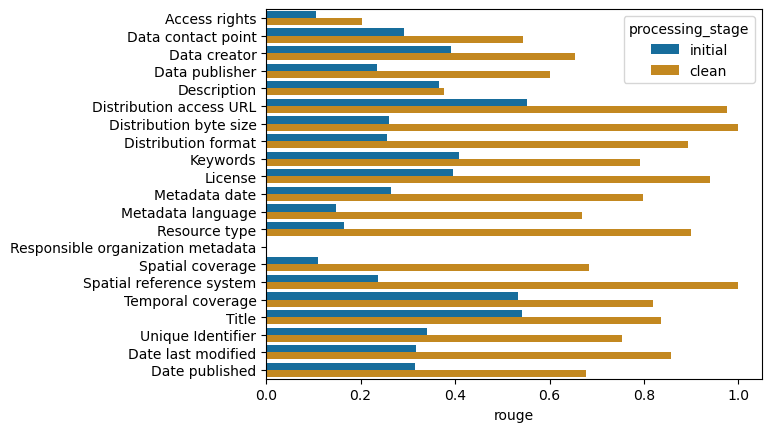

In [13]:
sns.barplot(data=df_scores_present_structured, x='rouge', y='metadata_field', hue='processing_stage', orient='h', errorbar=None)
plt.ylabel('')
# plt.title('Relevancy for exact metadata fields (present) pm sem')

In [18]:
df_scores[df_scores['metadata_field'] == 'Data contact point'].metadata_format.value_counts()

metadata_format
cedar    64
Name: count, dtype: int64

In [124]:
df_scores_present_structured_exact[df_scores_present_structured_exact['metadata_field'] == 'Title'].sort_values(by='rouge', ascending=False)

,url,llm_name,metadata_format,findability,metadata_field,rouge,levenshtein,annot_missing,value_annot,value_pred,domain,name
352,https://datahuiswadden.openearth.nl/geonetwork...,openai,cedar,1,Title,1.000000,1.000000,False,WMR - TMAP: Ecotopenkaart,WMR - TMAP: Ecotopenkaart,datahuiswadden.openearth.nl,Ecotopenkaart 2016 (Datahuis Wadden)
353,https://datahuiswadden.openearth.nl/geonetwork...,openai,cedar,1,Title,1.000000,1.000000,False,Waddenbalans 2024,Waddenbalans 2024,datahuiswadden.openearth.nl,Waddenbalans (Datahuis Wadden)
354,https://datahuiswadden.openearth.nl/geonetwork...,openai,cedar,1,Title,1.000000,1.000000,False,Ecotopenkaart Waddenzee (2017),Ecotopenkaart Waddenzee (2017),datahuiswadden.openearth.nl,Ecotopenkaart 2017 (Datahuis Wadden)
355,https://developers.google.com/earth-engine/dat...,openai,cedar,1,Title,1.000000,1.000000,False,HLSS30: HLS Sentinel-2 Multi-spectral Instrume...,HLSS30: HLS Sentinel-2 Multi-spectral Instrume...,developers.google.com,HLS (Google Earth Engine)
356,https://lifesciences.datastations.nl/dataset.x...,openai,cedar,1,Title,1.000000,1.000000,False,Dutch forest reserves database and network,Dutch forest reserves database and network,lifesciences.datastations.nl,Dutch forests (DANS)
358,https://stac.ecodatacube.eu/blue_glad.landsat....,openai,cedar,1,Title,1.000000,1.000000,False,Cloud-free reconstructed Landsat yearly blue band,Cloud-free reconstructed Landsat yearly blue band,ac.ecodatacube.eu,Landsat blue (EcoDataCube)
359,https://stac.ecodatacube.eu/green_glad.landsat...,openai,cedar,1,Title,1.000000,1.000000,False,Cloud-free reconstructed Landsat yearly green ...,Cloud-free reconstructed Landsat yearly green ...,ac.ecodatacube.eu,Landsat green (EcoDataCube)
361,https://stac.ecodatacube.eu/veg_quercus.robur_...,openai,cedar,1,Title,1.000000,1.000000,False,Actual probability distribution for Quercus ro...,Actual probability distribution for Quercus ro...,ac.ecodatacube.eu,Quercus robur (EcoDataCube)
362,https://www.gbif.org/dataset/4fa7b334-ce0d-4e8...,openai,cedar,1,Title,1.000000,1.000000,False,EOD – eBird Observation Dataset,EOD – eBird Observation Dataset,www.gbif.org,eBird (GBIF)
363,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,openai,cedar,1,Title,1.000000,0.989474,False,Camera trap data recorded during pilot studies...,'Camera trap data recorded during pilot studie...,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)


In [248]:
df_scores_exact_missing['relevancy'].isna().sum() / len(df_scores_exact_missing)

np.float64(0.6701030927835051)

In [242]:
df_scores_exact_missing[np.logical_not(df_scores_exact_missing['relevancy'].isna())]

,url,metadata_field,relevancy,faithfulness,rouge,levenshtein,annot_missing,domain,name
11,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Access rights,0.788648,0.0,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)
20,https://lpdaac.usgs.gov/products/mod09a1v061/,Data contact point,0.755360,1.0,0.000000,0.142857,True,lpdaac.usgs.gov,MODIS (LP DAAC)
38,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Data creator,0.756385,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat NDVI (EcoDataCube)
39,https://stac.ecodatacube.eu/veg_quercus.robur_...,Data creator,0.000000,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Quercus robur (EcoDataCube)
92,https://datahuiswadden.openearth.nl/geonetwork...,Distribution byte size,0.000000,1.0,0.000000,0.076923,True,datahuiswadden.openearth.nl,Ecotopenkaart 2017 (Datahuis Wadden)
101,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Distribution byte size,0.778306,0.0,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P1 (GBIF)
111,https://stac.ecodatacube.eu/blue_glad.landsat....,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat blue (EcoDataCube)
112,https://stac.ecodatacube.eu/green_glad.landsat...,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat green (EcoDataCube)
113,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Landsat NDVI (EcoDataCube)
114,https://stac.ecodatacube.eu/veg_quercus.robur_...,Distribution format,0.727068,0.0,0.000000,0.000000,True,ac.ecodatacube.eu,Quercus robur (EcoDataCube)


In [ ]:
url = df_scores_fuzzy_missing['url'].iloc[3]  # Example URL to check
col_evaluate = 'Keywords'  # Column to evaluate, e.g., 'Description', 'Title', etc.
field_annot = labels_annot.get_text(url, col_evaluate)
assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
field_pred = labels_pred.get_text(url, col_evaluate)
if field_pred is None:
    field_pred = ''
    
print(f"Dataset name: {url_to_ds_name[url]}")
print(f"Predicted: {field_pred}")
print(f"Annotated: {field_annot}")

df_scores[df_scores['url'] == url]

Dataset name: Waterleidingduinen camera trap P3 (GBIF)
Predicted: Camera trap, lens angle, camera height, herbivore exclosures
Annotated: N/A


,url,metadata_field,relevancy,faithfulness,rouge,levenshtein,annot_missing,domain,name
12,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Access rights,NaN,1.000000,1.000000,1.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
27,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data contact point,0.770615,0.333333,0.583333,0.414414,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
42,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data creator,0.826349,1.000000,0.428571,0.413043,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
57,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Data publisher,0.749243,0.000000,0.000000,0.301887,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
72,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Description,0.759030,1.000000,0.207254,0.175000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
87,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution access URL,0.000000,1.000000,1.000000,1.000000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
102,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution byte size,NaN,1.000000,1.000000,1.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
117,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Distribution format,0.000000,1.000000,0.000000,0.125000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
132,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Keywords,0.750340,0.000000,0.000000,0.000000,True,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
147,https://www.gbif.org/dataset/bc0acb9a-131f-408...,License,0.804843,1.000000,1.000000,1.000000,False,www.gbif.org,Waterleidingduinen camera trap P3 (GBIF)
